# Лабораторная работа №6 - Планирование траектории движения манипулятора
### Абрамов Максим Витальевич R4134с
### Цель:
> Разработать программу планирования траектории движения манипуляционного робота через заданные точки в декартовом пространстве.
### Задачи:
 > 1. Выбрать модель манипулятора.
 > 2. Решить задачи прямой и обратной кинематики.
 > 3. Определить 4 целевые точки в пространстве.
 > 4. Реализовать кубическую траекторию между точками.
 > 5. Произвести расчёт параметров функций времени.
 > 6. Визуализировать движение манипулятора и траекторию в 3D.


### Импорт библиотек

In [1]:
# Импортируем необходимые библиотеки
import numpy as np                  # Для работы с массивами и математикой
from roboticstoolbox import models  # Модели роботов из roboticstoolbox
from spatialmath import SE3         # Для работы с гомогенными преобразованиями
import matplotlib.pyplot as plt     # Для построения графиков

### Выбор модели манипулятора

In [2]:
# Загружаем модель промышленного робота IRB140
robot = models.DH.IRB140()

### Определение целевых точек в декартовом пространстве

In [3]:
# Определяем 4 точки в 3D-пространстве с ориентацией
points = [
    SE3(0.6, -0.2, 0.3) * SE3.Rz(np.pi),      # Точка 1 — позиция + поворот вокруг Z
    SE3(0.4, 0.0, 0.5) * SE3.Rz(np.pi),       # Точка 2
    SE3(0.3, 0.3, 0.4) * SE3.Ry(np.pi / 2),   # Точка 3 — поворот вокруг Y
    SE3(0.5, -0.1, 0.2) * SE3.Rx(np.pi / 2),  # Точка 4 — поворот вокруг X
]

# Выводим координаты каждой точки
for i, point in enumerate(points):
    print(f"Точка {i+1}:\n{point}")

Точка 1:
  -1         0         0         0.6       
   0        -1         0        -0.2       
   0         0         1         0.3       
   0         0         0         1         

Точка 2:
  -1         0         0         0.4       
   0        -1         0         0         
   0         0         1         0.5       
   0         0         0         1         

Точка 3:
   0         0         1         0.3       
   0         1         0         0.3       
  -1         0         0         0.4       
   0         0         0         1         

Точка 4:
   1         0         0         0.5       
   0         0        -1        -0.1       
   0         1         0         0.2       
   0         0         0         1         



### Обратная кинематика (расчёт обобщённых координат)

In [4]:
# Список для хранения углов (q) для каждой точки
q_points = []

# Решаем обратную задачу кинематики для каждой точки
for i, T in enumerate(points):
    q_sol = robot.ikine_LM(T)  # Используем метод Левенберга-Марквардта
    if q_sol.success:
        q_points.append(q_sol.q)
        print(f"\nУглы для точки {i+1}:")
        print(np.round(q_sol.q, 4))  # Выводим значения с округлением


Углы для точки 1:
[-0.3218  0.9093 -2.9353 -3.1416  1.1156 -2.8198]

Углы для точки 2:
[3.1416 2.4141 0.1697 0.     0.5578 3.1416]

Углы для точки 3:
[ 0.9063  1.0367  2.448  -0.9352  1.3619 -2.8675]

Углы для точки 4:
[-0.0699 -0.6007  0.2397  1.5054 -1.5461 -1.9311]


### Задание временных параметров

In [5]:
# Параметры траектории
t_total = 10         # Общее время движения в секундах
N = 100              # Число шагов дискретизации
times = np.linspace(0, t_total, len(points))  # Моменты времени достижения целевых точек

### Расчёт параметров кубических траекторий между точками

In [6]:
def cubic_coefficients(q0, qf, t0, tf, v0=0, vf=0):
    """
    Функция рассчитывает коэффициенты кубического полинома:
    q(t) = a0 + a1*t + a2*t^2 + a3*t^3
    При условии:
    - q(t0) = q0
    - q(tf) = qf
    - v(t0) = v0 (скорость в начальной точке)
    - v(tf) = vf (скорость в конечной точке)
    """
    A = np.array([
        [1, t0, t0**2, t0**3],
        [0, 1, 2*t0, 3*t0**2],
        [1, tf, tf**2, tf**3],
        [0, 1, 2*tf, 3*tf**2]
    ])
    b = np.array([q0, v0, qf, vf])
    return np.linalg.solve(A, b)

# Храним коэффициенты для каждого участка и сустава
segments = []

# Проходим по всем парам точек
for i in range(len(points) - 1):
    coeffs = []
    for j in range(robot.n):  # Для каждого сустава
        a = cubic_coefficients(
            q_points[i][j],     # Начальный угол
            q_points[i+1][j],   # Конечный угол
            times[i],           # Начальное время
            times[i+1]          # Конечное время
        )
        coeffs.append(a)
    segments.append(coeffs)

### Построение траектории как функции времени

In [7]:
# Создаём равномерную временную сетку
t_all = np.linspace(0, t_total, N)

# Массив для хранения всех обобщённых координат
q_path = np.zeros((N, robot.n))

# Вычисляем q(t) для каждого момента времени
for i, t in enumerate(t_all):
    # Определяем, на каком участке находится текущее время
    for seg_idx in range(len(segments)):
        if times[seg_idx] <= t <= times[seg_idx + 1]:
            for j in range(robot.n):
                a = segments[seg_idx][j]
                q_path[i, j] = a[0] + a[1]*t + a[2]*t**2 + a[3]*t**3
            break

### Прямая кинематика для построения траектории в декартовом пространстве

In [8]:
# Вычисляем положение конца манипулятора для каждого угла
Ts = [robot.fkine(q) for q in q_path]

### Визуализация — Траектория в 3D

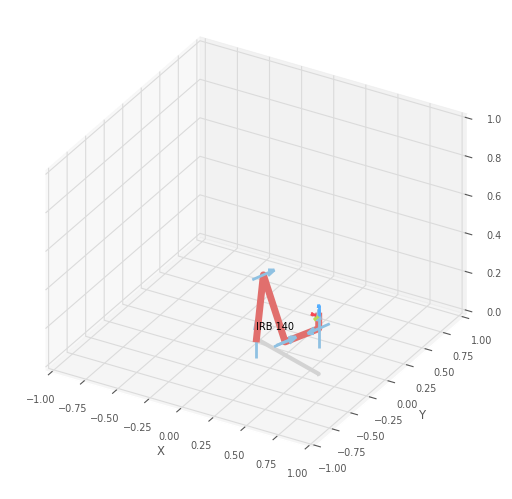

<Figure size 640x480 with 0 Axes>

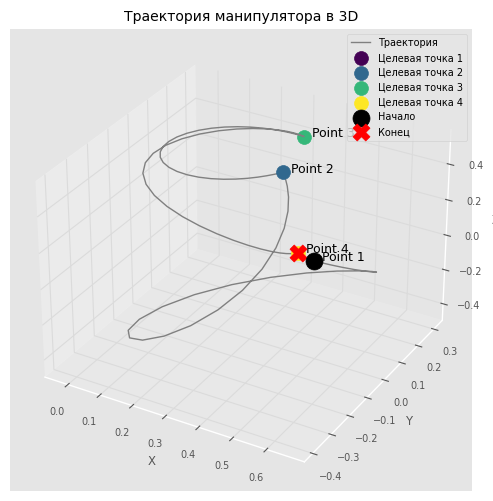

In [9]:
# Анимируем движение робота по найденной траектории
robot.plot(q_path, backend='pyplot', block=False, limits=[-1, 1, -1, 1, 0, 1])

# Подготавливаем данные для визуализации траектории в 3D
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(projection='3d')

positions = np.array([T.t for T in Ts])
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], c='gray', lw=1, label="Траектория")

# Цветовая шкала для точек
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=0, vmax=len(points)-1)

# Отображаем целевые точки
for i, T in enumerate(points):
    ax.scatter(T.t[0], T.t[1], T.t[2], c=[cmap(norm(i))], s=100, label=f'Целевая точка {i+1}')

# Начальная и конечная точки
ax.scatter(points[0].t[0], points[0].t[1], points[0].t[2], c='black', s=150, marker='o', label='Начало')
ax.scatter(points[-1].t[0], points[-1].t[1], points[-1].t[2], c='red', s=150, marker='X', label='Конец')

# Подписи точек
for i, point in enumerate(points):
    ax.text(point.t[0], point.t[1], point.t[2], f'  Point {i+1}', color='black', fontsize=9)

# Настройки графика
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("Траектория манипулятора в 3D")
plt.legend()
plt.show()

### Выводы:
> В ходе работы была реализована программа построения траектории движения манипулятора через заданные точки. Использованы методы прямой и обратной кинематики для перевода траектории из декартова пространства в пространство обобщённых координат. Реализованы кубические траектории с явным расчётом коэффициентов полинома для каждого участка. Построены графики и проведена визуализация движения манипулятора. Полученные результаты позволяют использовать данную программу для управления реальными роботами в задачах позиционирования.

